In [124]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.dom.minidom as xmldom

In [125]:
class Ldk_300W_Dataset(Dataset):
    def __init__(self, xmlfile, root_dir, transform=None):
        document = xmldom.parse(xmlfile)
        annos = document.getElementsByTagName("image")
        self.records = []
        for anno in annos:
            parts = anno.getElementsByTagName("part")
            landmark = []
            for part in parts:
                landmark.append(part.getAttribute("x"))
                landmark.append(part.getAttribute("y"))
            record = [anno.getAttribute("file"), landmark]
            self.records.append(record)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.records)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.records[idx][0])
        image = io.imread(img_name)
        landmarks = map(float, self.records[idx][1])
        landmarks = np.asarray(landmarks).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample
    def show(self,idx):
        record = self[idx]
        plt.scatter(record['landmarks'][:,0], record['landmarks'][:,1], s=10, marker='.', c='r')
        plt.imshow(record['image'])
#transform
class CropByLDK(object):
    def __init__(self, scale):
        assert isinstance(scale, float)
        if isinstance(scale, float):
            self.scale = scale
        else:
            self.scale = 0.2
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        left, right = int(landmarks[:,0].min()), int(landmarks[:,0].max())
        top, bottom = int(landmarks[:,1].min()), int(landmarks[:,1].max())
        height, width = bottom - top, right - left
        
        image = image[top:bottom, left:right]
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks':landmarks}

In [126]:
path_300w = '/home/whale/dataset/Landmark/300W'
path_train = os.path.join(path_300w, "train.xml")
path_test = os.path.join(path_300w, "test.xml")
path_all = os.path.join(path_300w, "all.xml")
transform = CropByLDK(0.2)
#inall = Ldk_300W_Dataset(path_all,path_300w)
#train = Ldk_300W_Dataset(path_train, path_300w)
test = Ldk_300W_Dataset(path_test, path_300w, transform)

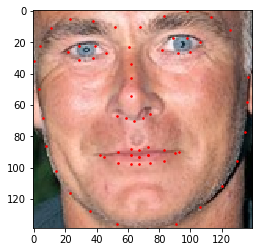

In [127]:
test.show(2)